# 09. Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes

### Download helper function script

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-23 00:57:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-01-23 00:57:05 (17.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [7]:
# Create a function to read the lines of a document

def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # Read the lines within the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

In [10]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename) # Get all lines from filename
    abstract_lines = "" # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # Check to see if there is an ID line
            abstract_id = line
            abstract_lines = "" # Reset the abstract string if the line is an ID line
        elif line.isspace(): # Check to see if the line is a new line
            abstract_line_split = abstract_lines.splitlines() # Split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # Split target label from the text
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data) # Add line data to abstract samples list
        else:
            abstract_lines += line

    return abstract_samples

In [11]:
%%time
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # Validation data
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 640 ms, sys: 104 ms, total: 744 ms
Wall time: 813 ms


In [12]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

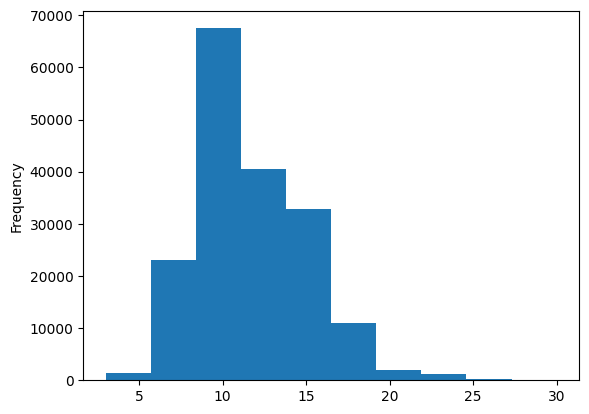

In [15]:
# Lets check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [18]:
import sklearn
sklearn.__version__

'1.6.0'

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot, val_labels_one_hot, test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [20]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments ...

We're going to start with a baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [23]:
## Model 0: Getting a baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [25]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
from helper_functions import calculate_results

In [27]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [30]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

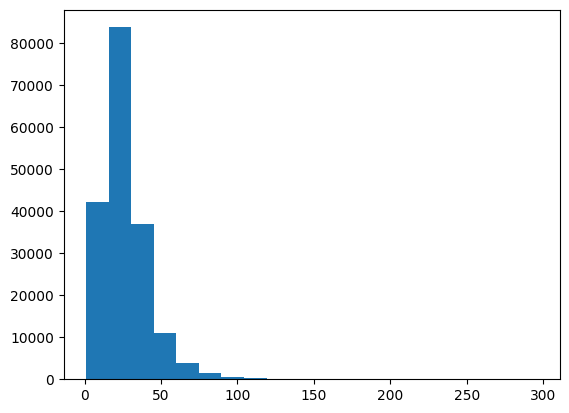

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [32]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [34]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [35]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [36]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
running in minimalist footwear appears to increase the likelihood of experiencing an injury , with full minimalist designs specifically increasing pain at the shin and calf .

Length of text: 27

Vectorized text: [[ 3650     5 16914  8455  1403     6   179     2  1927     4  2461    26
    503     7  1186 16914  4543  1850   575    65    15     2 24626     3
   6979     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [38]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [40]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # Length of vocabulary
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [41]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 running in minimalist footwear appears to increase the likelihood of experiencing an injury , with full minimalist designs specifically increasing pain at the shin and calf .

Sentence after vectorization (before embedding):
 [[ 3650     5 16914  8455  1403     6   179     2  1927     4  2461    26
    503     7  1186 16914  4543  1850   575    65    15     2 24626     3
   6979     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.04090849 -0.02981748  0.02193839 ... -0.02019826 -0.02355088
   -0.04591267]
  [-0.00855073  0.02740614  0.01204041 ...  0.01877669 -0.04875361
   -0.012079  ]
  [ 0.02207654 -0.03060789 -0.00493519 ...  0.0057048  -0.00158151
    0.03924037]
  ...
  [ 0.03252285  0.01245667  0.02206016 ... -0.02345157  0.00861473
   -0.01564871]
  [ 0.03252285  0.01245667  0.0220

## Creating datasets (making sure our data loads as fast as possible)

In [42]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # No need to shuffle train dataset here because we need to preserve the order of the dataset in SkimLit & We want our model to learn order here

valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [44]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # We want our model to look at 10% of batches every epochs
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # Only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 22s 35ms/step - loss: 0.9146 - accuracy: 0.6345 - val_loss: 0.6834 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6543 - accuracy: 0.7581 - val_loss: 0.6303 - val_accuracy: 0.7759
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6147 - accuracy: 0.7769 - val_loss: 0.5960 - val_accuracy: 0.7852


In [47]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5970 - accuracy: 0.7873


[0.5970310568809509, 0.7873030304908752]

In [48]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.8716205e-01, 1.6128822e-01, 5.8044709e-02, 2.6777691e-01,
         2.5728164e-02],
        [3.8292038e-01, 3.4891602e-01, 1.3886398e-02, 2.4350058e-01,
         1.0776690e-02],
        [1.4502038e-01, 5.3686551e-03, 1.5588931e-03, 8.4801596e-01,
         3.6049059e-05],
        [1.8178045e-05, 2.2405281e-04, 9.8362422e-01, 1.4773968e-05,
         1.6118709e-02],
        [1.4933728e-03, 4.5488250e-02, 3.3471119e-01, 9.6053345e-04,
         6.1734670e-01],
        [2.0218613e-02, 2.8707370e-02, 5.5815756e-01, 8.9522600e-03,
         3.8396424e-01],
        [4.8123402e-04, 4.0575615e-03, 2.3695202e-01, 1.7477895e-04,
         7.5833434e-01],
        [2.6573848e-02, 2.5291432e-02, 6.7654151e-01, 1.3552523e-02,
         2.5804067e-01],
        [4.7150397e-13, 1.8940426e-08, 9.4254688e-08, 6.4698294e-14,
         9.9999988e-01],
        [1.3021170e-02, 6.5846950e-01, 6.3770749e-02, 2.3500003e-02,
         2.4123855e-01]], dtype=float32),
 (30212, 5))

In [49]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>

In [50]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=np.array(model_1_preds))
model_1_results

{'accuracy': 78.73030583873958,
 'precision': 0.7844558399726699,
 'recall': 0.7873030583873958,
 'f1': 0.7849004062691833}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")# Download pretrained TensorFlow Hub USE

In [53]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 to assess the efficacy of aromatic essential oils on neck pain .
Setence after embedding:
[ 0.02792885 -0.0125427   0.01831497 -0.02939063  0.03765902  0.02101034
 -0.01672476 -0.04976942  0.00310862  0.04604829  0.04750001 -0.03106261
  0.03832712  0.00976914  0.01737618 -0.02710353 -0.06000276 -0.06029456
  0.04518081 -0.05001767 -0.06573932  0.05868814 -0.05445765 -0.03572158
 -0.05062305  0.01818223  0.00245969 -0.04988097  0.05181261 -0.01495217]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [54]:
# Define feature extraction model using TF Hub layer
from tensorflow.keras import layers
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # Tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x) # Create the output layer

model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 13ms/step - loss: 0.9188 - accuracy: 0.6491 - val_loss: 0.7973 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7677 - accuracy: 0.7032 - val_loss: 0.7533 - val_accuracy: 0.7088
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7499 - accuracy: 0.7132 - val_loss: 0.7376 - val_accuracy: 0.7174


In [56]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7398 - accuracy: 0.7139


[0.7397618293762207, 0.7139216065406799]

In [57]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 11s 11ms/step


array([[4.2095992e-01, 3.6198044e-01, 2.4637927e-03, 2.0771231e-01,
        6.8836338e-03],
       [3.4670335e-01, 4.9971318e-01, 4.5255395e-03, 1.4668748e-01,
        2.3704397e-03],
       [2.4004547e-01, 1.5925947e-01, 1.9681105e-02, 5.3923392e-01,
        4.1780006e-02],
       [1.5748614e-02, 4.1372851e-02, 8.3396059e-01, 9.5620714e-03,
        9.9355839e-02],
       [3.8697384e-02, 2.5125158e-01, 2.3157634e-01, 1.5489548e-02,
        4.6298507e-01],
       [1.1928384e-03, 3.1534587e-03, 6.6289127e-01, 1.6310894e-04,
        3.3259934e-01],
       [2.5609022e-03, 4.1052559e-03, 6.1665940e-01, 1.5210997e-03,
        3.7515330e-01],
       [5.0685001e-03, 2.4020549e-02, 5.2284014e-01, 1.2475126e-03,
        4.4682330e-01],
       [9.0942380e-04, 7.5664213e-03, 2.1666685e-02, 1.1481353e-03,
        9.6870929e-01],
       [1.2688892e-01, 7.1075177e-01, 2.3068754e-02, 7.6810397e-02,
        6.2480159e-02]], dtype=float32)

In [58]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 2, 4, 1])>

In [59]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded, y_pred=np.array(model_2_preds))
model_2_results

{'accuracy': 71.39216205481266,
 'precision': 0.7142942798735947,
 'recall': 0.7139216205481266,
 'f1': 0.7109476277906333}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [60]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [61]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't o   a s s e s s   t h e   e f f i c a c y   o f   a r o m a t i c   e s s e n t i a l   o i l s   o n   n e c k   p a i n   .'

In [62]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [63]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

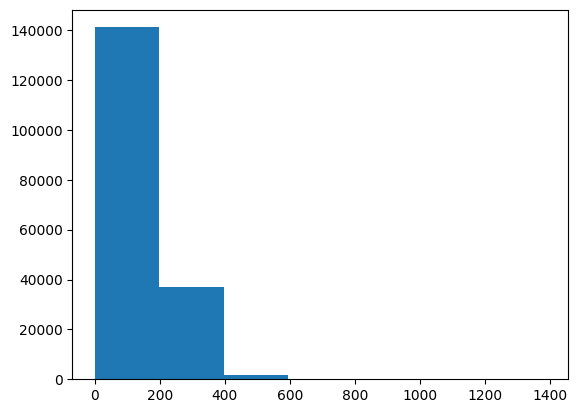

In [64]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [65]:
# Find what character length cover 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [66]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [84]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Add 2 for space and OOV token (OOV = Out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [85]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [86]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['|', '"', ']', '\\', '[']


In [87]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   s r t   s e e m s   t o   b e   a   q u i c k   ,   c o n v e n i e n t   ,   a n d   l o w - c o s t   e x e r c i s e   t e s t   t h a t   i s   w e l l - t o l e r a t e d   i n   p a t i e n t s   w i t h   c f   w i t h   m i l d - t o - m o d e r a t e   a i r w a y   o b s t r u c t i o n   .

Length of random_train_chars: 130

Vectorized chars:
 [[ 3 13  2  9  8  3  9  2  2 15  9  3  7 23  2  5 34 16  4 11 29 24 11  7
   6 22  2  6  4  2  6  3 24  5  6 10 12  7 21 26 11  7  9  3  2 30  2  8
  11  4  9  2  3  2  9  3  3 13  5  3  4  9 21  2 12 12 26  3  7 12  2  8
   5  3  2 10  4  6 14  5  3  4  2  6  3  9 21  4  3 13 11 17 21  4  3 13
  15  4 12 10 26  3  7 26 15  7 10  2  8  5  3  2  5  4  8 21  5 20  7 23
   9  3  8 16 11  3  4  7  6 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 

### Creating a character-level embedding

In [88]:
len(char_vocab)

57

In [89]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [90]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t h e   s r t   s e e m s   t o   b e   a   q u i c k   ,   c o n v e n i e n t   ,   a n d   l o w - c o s t   e x e r c i s e   t e s t   t h a t   i s   w e l l - t o l e r a t e d   i n   p a t i e n t s   w i t h   c f   w i t h   m i l d - t o - m o d e r a t e   a i r w a y   o b s t r u c t i o n   .

Embedded chars (after vectorization and embedding):
 [[[-0.00202782 -0.00261804 -0.04157102 ...  0.03357125  0.01804472
    0.01551357]
  [ 0.01826834 -0.00600683  0.01923743 ...  0.00082989  0.0288023
   -0.02578973]
  [ 0.02385365 -0.01922281 -0.03915938 ... -0.02494843 -0.04829219
   -0.02965713]
  ...
  [ 0.03583739  0.02656472 -0.01756635 ... -0.0277541  -0.03672277
   -0.01180315]
  [ 0.03583739  0.02656472 -0.01756635 ... -0.0277541  -0.03672277
   -0.01180315]
  [ 0.03583739  0.02656472 -0.01756635 ... -0.0277541  -0.03672277
   -0.01180315]]]
Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [102]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1, ), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [103]:
model_3.summary()

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 

In [104]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [105]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.0690 - accuracy: 0.5758 - val_loss: 0.8856 - val_accuracy: 0.6626
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8517 - accuracy: 0.6712 - val_loss: 0.8044 - val_accuracy: 0.7008
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.7906 - accuracy: 0.6976 - val_loss: 0.7538 - val_accuracy: 0.7191


In [106]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:5]

945/945 [==============================] - 3s 3ms/step


array([[0.21094817, 0.5419531 , 0.02878236, 0.20825559, 0.0100608 ],
       [0.15745658, 0.42358714, 0.00773235, 0.32267812, 0.08854581],
       [0.04320884, 0.25520924, 0.29047137, 0.28143042, 0.1296801 ],
       [0.003052  , 0.00761956, 0.95485395, 0.00249862, 0.03197582],
       [0.02851674, 0.22812326, 0.45858443, 0.04579147, 0.23898408]],
      dtype=float32)

In [107]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 2, 2, 2])>

In [108]:
# Calculate results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=np.array(model_3_preds))
model_3_results

{'accuracy': 70.84602144843109,
 'precision': 0.7138657372934962,
 'recall': 0.7084602144843108,
 'f1': 0.7011196153393054}